# Analyzing Tone for CSV file

We are analyzing tone for the 1200 lyrics(Training+Validation) data, using tone analyzer api

In [9]:
from flask import Flask, render_template, redirect, url_for, request
import requests as rq
import json
from watson_developer_cloud import ToneAnalyzerV3
import re
import os 
import pandas as pd
import operator

df = pd.read_csv(os.getcwd()+ "data/valid_lyrics_200.csv")
df=df.fillna(" ")

lyrics_list = []

def replaceMultiple(mainString, toBeReplaced, newString):
        # Iterate over the strings to be replaced
        for elem in toBeReplaced :
            # Check if string is in the main string
            if elem in mainString :                        
                # Replace the string
                mainString = mainString.replace(elem, newString)
        return  mainString 

for lyric in df['lyrics']:
    lyric = replaceMultiple(lyric,['\n','...','. . .','{','}','(',')'],' ')
    lyric = re.sub(' +',' ',lyric)
    lyrics_list.append(lyric)

def toneAnalyzer(lyrics):
    tone_analyzer = ToneAnalyzerV3(
        version='2016-05-19',
        iam_apikey='xRTFsyatVym6NfGc64o5oLwBfVABQicz396CjHuXy5y4',
        url='https://gateway-wdc.watsonplatform.net/tone-analyzer/api'
    )

    tone_analysis = tone_analyzer.tone(
        {'text': lyrics},
        'application/json',
        sentences = 'false',
        tones = 'emotion'
    ).get_result()
    tone= json.dumps(tone_analysis, indent=2)
    # converting the string obtained from json.dumps() to json format
    dcmnt_tone_json = json.loads(tone)
    dcmnt_tone = dcmnt_tone_json['document_tone']['tone_categories']

    
    # retrieving the dictionary in the list obtained in dcmnt_tone
    tone_category_dict = dcmnt_tone[0]
    
    dict_emotion = {}
    happy_sad_dict = {}
    for val in tone_category_dict['tones']:
        dict_score_emotion = {val['tone_name']:val['score']}
        dict_emotion.update(dict_score_emotion)
        if val['tone_name'] == 'Joy' or val['tone_name'] == 'Sadness':
            happy_sad = {val['tone_name']:val['score']}
            happy_sad_dict.update(happy_sad)   
    final_tone = max(happy_sad_dict.items(), key=operator.itemgetter(1))[0]
    if final_tone == 'Joy':
        final_tone = 'happy'
    else:
        final_tone = 'sad'
    return final_tone

tone_list1=[]
for l in lyrics_list:
    tone=toneAnalyzer(l)
    #print(tone)
    tone_list1.append(tone)
    #print("")


# Calculation of Confusion Matrix

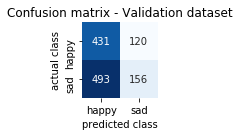

In [26]:
import matplotlib as mpl
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#validation data
X_valid = df['lyrics'].values 
y_valid = df['mood'].values

#predicted values
y_true=tone_list1

cm = metrics.confusion_matrix(y_valid, y_true)

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Validation dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.savefig('confmat_valid.eps', dpi=300)
plt.show()

# Inference
Heat map infers the highest number with the most dark shade, which is for false negative.

1.True positive - Tone is happy and we predicted happy

2.False Positive - Tone is happy but we predicted sad

3.False negative - Tone is sad but we predicted happy

4.True positive - Tone is sad and we predicted sad

In [33]:
#retriving values of TP,FP,FN and TN from confusion matrix

def print_confusion_matrix(y_valid, y_true):
    cm = confusion_matrix(y_valid, y_true)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    #print(TP,FP,FN,TN)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

print_confusion_matrix(y_valid, y_true)

True positive =  431
False positive =  120
False negative =  493
True negative =  156


(431, 120, 493, 156)

# Precision, Recall, F1 Score, Error Rate and Accuracy

In [37]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

#Calculating precision
def Precision_Cal(TP,FP):
    return TP/(TP+FP)

#Calculating recall
def Recall_Cal(TP,FP,FN):
    return TP/(FP+FN)

#Calculating F1 score
def F1_Cal(precision,recall):
    f1 = 2*((precision * recall)/(precision+recall))
    print('F1 Score = ', f1)
    print('F1 % = ', f1*100)

#Calculating Error Rate
def Err_Cal(TP,FP,FN,TN):
    return ((FP+FN)/(TP+FP+FN+TN))

precision = Precision_Cal(TP,FP)
print('Precision = ', precision)

recall = Recall_Cal(TP,FP,FN)
print('Recall = ', recall)

F1_Cal(precision,recall)

Err_Rate = Err_Cal(TP,FP,FN,TN)
print('Error Rate = ', Err_Rate)

#Accuracy is 1-error rate
print('Accuracy = ', 1-Err_Rate)

Precision =  0.7822141560798548
Recall =  0.7030995106035889
F1 Score =  0.7405498281786941
F1 % =  74.0549828178694
Error Rate =  0.5108333333333334
Accuracy =  0.48916666666666664


The best error rate is 0.0, whereas the worst is 1.0 and reverse for Accuracy